In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import math
import os

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, einsum
import torchio as tio
import torch.nn.functional as F
from scipy.ndimage import rotate, zoom
import random


from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [ ]:
BATCH_SIZE = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.df = dataframe
        self.transforms = transforms

    def __getitem__(self, index):
        path_object = self.df.loc[index]['mri_path']
        mri_file = '/workspace/data/SAG_3D_DESS_v2_full/MRI_Numpy/' + path_object
        mri_dict = np.load(mri_file)
        mri_object = mri_dict['data']

        mri_object = np.expand_dims(mri_object, 0) # (1 x 120 x 160 x 160)
        mri_object = self.transforms(mri_object)
        mri_tensor = torch.tensor(mri_object)

        label = self.df.loc[index]['kl_grade']

        return mri_tensor, label

    def __len__(self):
        return len(self.df)

In [ ]:
spatial_augment = {
    tio.RandomAffine(degrees=15, p=0.5),
    tio.RandomFlip(axes=(0), flip_probability=0.5)
}

intensity_augment = {
    tio.RandomNoise(): 0.25,
    tio.RandomBiasField(): 0.25,
    tio.RandomBlur(std=(0,1.5)): 0.25,
    tio.RandomMotion(): 0.25,
}

train_transforms = tio.Compose([
    tio.Compose(spatial_augment, p=1),
    # tio.OneOf(intensity_augment, p=0.75),
    tio.RescaleIntensity(out_min_max=(0,1)),
])

val_transforms = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0,1)),
])

test_transforms = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0,1)),
])


df = pd.read_csv('/workspace/data/unified_xray_mri_label.csv')

train_df = df[df['subset'] == 'train'].reset_index(drop=True)
val_df = df[df['subset'] == 'val'].reset_index(drop=True)
test_df = df[df['subset'] == 'test'].reset_index(drop=True)

train_ds = CustomDataset(train_df, transforms=train_transforms)
val_ds = CustomDataset(val_df, transforms=val_transforms)
test_ds = CustomDataset(test_df, transforms=test_transforms)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=8, pin_memory=True)

In [ ]:
for mri, label in train_loader:
    print(mri.shape)
    print(label.shape)
    print(torch.max(mri), torch.min(mri))
    break

torch.Size([8, 1, 120, 160, 160])
torch.Size([8])
tensor(1.) tensor(0.)


# Vision Transformer

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import copy


def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

class Awakening_Prompt(nn.Module):
    def __init__(self, dim, num_prompts, prompt_latent_dim=20):
        super().__init__()
        self.latent_dim = prompt_latent_dim
        self.num_prompts = num_prompts
        self.scale = dim ** -0.5
        # Projection layers
        self.proj_down = nn.Sequential(
            nn.Linear(dim, self.latent_dim),
            QuickGELU()
        )
        self.proj_up = nn.Linear(self.latent_dim, dim)

        # CLS token analysis for prompt importance (Prompt Relevant Estimator)
        self.cls_analyzer = nn.Sequential(
            nn.LayerNorm(self.latent_dim),
            nn.Linear(self.latent_dim, 64),
            nn.GELU(),
            nn.Linear(64, num_prompts),
            nn.Sigmoid()
        )

        # Global-Local balancer (dynamic per layer) (Prompt Context Fusion)
        self.gl_balancer = nn.Sequential(
            nn.LayerNorm(self.latent_dim),
            nn.Linear(self.latent_dim, 1),
            nn.Sigmoid()
        )

        # Separate queries for global and local path
        self.global_query = nn.Linear(self.latent_dim, self.latent_dim)
        self.local_query = nn.Linear(self.latent_dim, self.latent_dim)

        self.attend = nn.Softmax(dim=-1)

    def forward(self, x, local_tokens):
        """
        x: [B, num_prompts + 1 + N, dim] - Global tokens (prompts + cls + image)
        local_tokens: [B, N, dim] - Local tokens (only image)
        """
        # Project to latent space
        x_latent = self.proj_down(x)
        local_latent = self.proj_down(local_tokens)

        # Extract components
        prompts_latent = x_latent[:, :self.num_prompts]  # [B, num_prompts, latent_dim]
        cls_latent = x_latent[:, self.num_prompts:self.num_prompts+1]  # [B, 1, latent_dim]
        global_img_latent = x_latent[:, self.num_prompts+1:]  # [B, N, latent_dim]

        # Analyze CLS token to determine prompt importance
        prompt_importance = self.cls_analyzer(cls_latent)  # [B, 1, num_prompts]

        # Determine global-local balance from CLS token
        global_weight = self.gl_balancer(cls_latent)  # [B, 1, 1]

        # GLOBAL PATH: Cross-attention between prompts and global image tokens
        global_q = self.global_query(prompts_latent)  # [B, num_prompts, latent_dim]
        global_attn = torch.einsum('bpd,bnd->bpn', global_q, global_img_latent) * self.scale
        global_attn = self.attend(global_attn)
        global_context = torch.einsum('bpn,bnd->bpd', global_attn, global_img_latent)

        # LOCAL PATH: Cross-attention between prompts and local context
        local_q = self.local_query(prompts_latent)  # [B, num_prompts, latent_dim]
        local_attn = torch.einsum('bpd,bnd->bpn', local_q, local_latent) * self.scale
        local_attn = self.attend(local_attn)
        local_context = torch.einsum('bpn,bnd->bpd', local_attn, local_latent)

        # Dynamic fusion of global and local context
        fused_prompts = global_weight * global_context + (1 - global_weight) * local_context

        # Apply prompt importance
        enhanced_prompts = fused_prompts * prompt_importance.transpose(1, 2)

        # Combine components
        combined_latent = torch.cat([
            enhanced_prompts,
            cls_latent,
            global_img_latent
        ], dim=1)

        return self.proj_up(combined_latent)


class LocalSelfAttention(nn.Module):
    def __init__(self,
                 dim,
                 local_k=(3, 6, 6),
                 DHW=None,
                 attn_drop=0.0,
                 proj_drop=0.0,
                 local_dim=20,
                 qkv_bias=False):
        super().__init__()
        self.dim = dim
        self.scale = dim ** -0.5
        self.latent_dim=local_dim
        self.norm = nn.LayerNorm(dim)
        self.proj_down = nn.Linear(dim, self.latent_dim)
        self.qkv = nn.Linear(self.latent_dim, self.latent_dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_up = nn.Linear(self.latent_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.DHW = DHW  # (D, H, W)

        if DHW is not None:
            D, H, W = DHW
            dk, hk, wk = local_k
            N = D * H * W  # 1000 (Image tokens)

            # Init mask Image Tokens (N, N)
            mask = torch.ones((N, D + dk - 1, H + hk - 1, W + wk - 1), dtype=torch.float32)
            for d in range(D):
                for h in range(H):
                    for w in range(W):
                        mask[d * H * W + h * W + w, d:d + dk, h:h + hk, w:w + wk] = 0.0

            mask_pytorch = mask[:, dk // 2:D + dk // 2, hk // 2:H + hk // 2, wk // 2:W + wk // 2].reshape(N, -1)
            mask_inf = torch.full((N, N), float('-inf'), dtype=torch.float32)
            local_mask = torch.where(mask_pytorch < 1, mask_pytorch, mask_inf)  # (N, N)
            self.mask = local_mask.unsqueeze(0)  # (1, N, N)

    def forward(self, x):
        B, N, C = x.shape  # N = num_prompt + image_tokens
        x_latent = self.proj_down(self.norm(x)) # B, N, latent_dim
        qkv = self.qkv(x_latent).chunk(3, dim=-1)  # (3, B, N, latent_dim)
        q, k, v = qkv

        attn = q @ k.transpose(-2, -1) * self.scale  # (B, N, N)
        if self.DHW is not None:
            attn = attn + self.mask.expand_as(attn).to(attn.device)  # (B, N, N) -> broadcast
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)

        x_out = (attn @ v)
        x_out = self.proj_up(x_out) # (B, N, dim)
        x_out = self.proj_drop(x_out)
        return x_out

class Transformer(nn.Module):
    def __init__(self,
                 dim,
                 depth,
                 heads,
                 dim_head,
                 mlp_dim,
                 num_prompts,
                 prompt_latent_dim,
                 DHW,
                 local_k,
                 share_factor=1,  # Parameter for sharing (s)
                 attn_drop=0.,
                 proj_drop=0.,
                 local_dim=20,
                 dropout=0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.num_prompts = num_prompts
        self.depth = depth
        self.share_factor = share_factor

        num_unique_components = math.ceil(depth / share_factor)

        self.local_attns = nn.ModuleList([
            LocalSelfAttention(dim, local_k, DHW, attn_drop, proj_drop, local_dim, qkv_bias=False)
            for _ in range(num_unique_components)
        ])

        self.prompt_projs = nn.ModuleList([
            Awakening_Prompt(dim, num_prompts, prompt_latent_dim)
            for _ in range(num_unique_components)
        ])

        self.attns = nn.ModuleList([
            Attention(dim, heads, dim_head, dropout)
            for _ in range(depth)
        ])

        self.mlps = nn.ModuleList([
            FeedForward(dim, mlp_dim, dropout)
            for _ in range(depth)
        ])

    def forward(self, global_tokens, local_tokens):
        """
        global_tokens: [B, num_prompts + 1 + N, dim] (prompts + cls + image tokens)
        local_tokens: [B, N, dim] (only image tokens)
        """
        local_features = local_tokens

        for i in range(self.depth):
            shared_idx = i // self.share_factor

            local_features = self.local_attns[shared_idx](local_features) + local_features
            global_tokens = self.attns[i](global_tokens) + global_tokens
            prompt = self.prompt_projs[shared_idx](global_tokens, local_features)
            global_tokens = self.mlps[i](global_tokens) + global_tokens + prompt

        return self.norm(global_tokens)

class AdaptiveFusionHead(nn.Module):
    def __init__(self, dim, num_prompts, num_classes):
        super().__init__()
        self.head = nn.Linear(dim, num_classes)
        self.num_prompts = num_prompts

    def forward(self, x):
        bs, _, dim = x.shape
        out = self.head(x[:, 0:self.num_prompts+1].mean(dim=1))  # (bs, num_classes)  Prompt-CLS Pool
        # out = self.head(x[:,self.num_prompts])  # (bs, num_classes) # CLS Pool
        # out = self.head(x[:, 0:self.num_prompts].mean(dim=1)) # Prompt Pool
        # out = self.head(x[:,self.num_prompts+1:].mean(dim=1)) # Image Pool

        # prompt = x[:,0:self.num_prompts]
        # image = x[:,self.num_prompts+1:]
        # out = torch.cat([prompt, image], dim=1)
        # out = self.head(out) # Prompt-Image Pool
        return out

class VisionTransformer(nn.Module):
    def __init__(self,
                 *,
                 image_size,
                 image_patch_size,
                 frames,
                 frame_patch_size,
                 num_classes,
                 dim, depth,
                 heads,
                 mlp_dim,
                 pool = 'cls',
                 channels = 1,
                 dim_head = 64,
                 dropout = 0.,
                 emb_dropout = 0.,
                 pretrain_path=None,
                 num_prompts=8,
                 prompt_latent_dim=20,
                 local_dim=20,
                 local_k=(3,6,6),
                 DHW = (10,10,10),
                 attn_drop = 0.2,
                 proj_drop = 0.2,
                 freeze_vit=False,
                 share_factor = 1,
                ):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(image_patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        assert frames % frame_patch_size == 0, 'Frames must be divisible by frame patch size'

        num_patches = (image_height // patch_height) * (image_width // patch_width) * (frames // frame_patch_size)
        patch_dim = channels * patch_height * patch_width * frame_patch_size
        self.num_patches = num_patches
        self.image_size = image_size
        self.image_patch_size = image_patch_size
        self.frames = frames
        self.frame_patch_size=frame_patch_size
        self.num_prompts = num_prompts
        self.local_dim = local_dim
        self.local_k = local_k
        self.prompt_latent_dim = prompt_latent_dim

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.conv_proj = nn.Sequential(
            nn.Conv3d(channels, dim, kernel_size=(frame_patch_size, image_patch_size, image_patch_size), stride=(frame_patch_size, image_patch_size, image_patch_size),
        ))

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim,
                                       depth,
                                       heads,
                                       dim_head,
                                       mlp_dim,
                                       num_prompts,
                                       prompt_latent_dim,
                                       DHW,
                                       local_k,
                                       share_factor,
                                       attn_drop,
                                       proj_drop,
                                       local_dim,
                                       dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        ##########################################
        '''
        Adaptive Fusion Head
        '''
        self.mlp_head = AdaptiveFusionHead(dim, num_prompts, num_classes)

        ##########################################
        '''
        Prompt Generator
        '''
        scale = dim ** -0.5
        self.prompt_positional_embedding = nn.Parameter(scale * torch.randn(1, num_prompts, dim))
        self.prompt_embeddings = nn.Parameter(torch.randn(1, num_prompts, dim))

        ##########################################

        self.freeze_vit = freeze_vit
        if self.freeze_vit:
            for k, p in self.named_parameters():
                if ("transformer" in k or "cls_token" in k or "conv_proj" in k or "pos_embedding" in k): # or "overlap_proj" in k):# or "fusion_attn" in k):
                    p.requires_grad = False
                if ("head" in k or "prompt" in k or "local_attn" in k):
                    p.requires_grad = True

        if pretrain_path is not None:
            print(f'Loading pretrained {pretrain_path}...')
            self.load_pretrain(pretrain_path)
            print(f'Load pretrained {pretrain_path} sucessfully!')

        self.init_weights()

    def init_weights(model, scale_factor=1.0):
        """
        initialization of the model parameters
        """
        # 1. Initialize prompt embeddings - Theo phân phối truncated normal
        with torch.no_grad():
            # Prompt embeddings theo phân phối chuẩn cắt ngọn với độ lệch chuẩn nhỏ
            # để khởi tạo feature gần 0 (neutral starting point)
            dim = model.prompt_embeddings.shape[-1]
            std = 0.02 * scale_factor
            model.prompt_embeddings.data.normal_(mean=0.0, std=std)
            model.prompt_embeddings.data = torch.clamp(model.prompt_embeddings.data, min=-2*std, max=2*std)

            # Positional embeddings với biên độ nhỏ hơn để có gradient ổn định
            pos_std = 0.01 * scale_factor
            model.prompt_positional_embedding.data.normal_(mean=0.0, std=pos_std)
            print(f"Initializing prompt embeddings have {model.num_prompts} prompts ...")

        # 2. Initialize Awakening_Prompt modules
        for prompt_proj in model.transformer.prompt_projs:

            # Projection layers - Xavier/Glorot initialization với gain nhỏ để gradient flows tốt hơn
            nn.init.xavier_uniform_(prompt_proj.proj_down[0].weight, gain=0.7*scale_factor)
            nn.init.zeros_(prompt_proj.proj_down[0].bias)
            nn.init.xavier_uniform_(prompt_proj.proj_up.weight, gain=0.7*scale_factor)
            nn.init.zeros_(prompt_proj.proj_up.bias)

            # Query projections - Orthogonal initialization for attention
            nn.init.orthogonal_(prompt_proj.global_query.weight, gain=scale_factor)
            nn.init.zeros_(prompt_proj.global_query.bias)
            nn.init.orthogonal_(prompt_proj.local_query.weight, gain=scale_factor)
            nn.init.zeros_(prompt_proj.local_query.bias)

            # CLS analyzer - Xavier initialization với bias=0
            # Sigmoid layer cuối có bias lớn hơn 0 để bắt đầu với giá trị gần 0.5
            nn.init.xavier_uniform_(prompt_proj.cls_analyzer[1].weight, gain=1.0)
            nn.init.zeros_(prompt_proj.cls_analyzer[1].bias)
            nn.init.xavier_uniform_(prompt_proj.cls_analyzer[3].weight, gain=1.0)
            nn.init.constant_(prompt_proj.cls_analyzer[3].bias, 0.0)  # Sigmoid(0) = 0.5

            # Global-Local balancer - Bias to start slightly global-dominated
            nn.init.xavier_uniform_(prompt_proj.gl_balancer[1].weight, gain=1.0)
            nn.init.constant_(prompt_proj.gl_balancer[1].bias, 0.5)  # Bias để bắt đầu với global:0.62, local:0.38
        print(f"Initializing Prompt Awakener with prompt latent dim {model.prompt_latent_dim}...")

        # 3. Initialize LocalSelfAttention layers
        for local_attn in model.transformer.local_attns:
            # Input Projection
            nn.init.xavier_uniform_(local_attn.proj_down.weight, gain=0.5*scale_factor)  # Smaller gain for stable training
            nn.init.zeros_(local_attn.proj_down.bias)

            # QKV projection - trọng số QKV được scale để tránh gradient vanishing
            nn.init.xavier_uniform_(local_attn.qkv.weight, gain=1.0)
            if local_attn.qkv.bias is not None:
                nn.init.zeros_(local_attn.qkv.bias)

            # Output projection
            nn.init.xavier_uniform_(local_attn.proj_up.weight, gain=0.5*scale_factor)  # Smaller gain for stable training
            nn.init.zeros_(local_attn.proj_down.bias)
        print(f"Initializing local context Extractor with Local Window size {model.local_k} and Local latent dimension {model.local_dim} ...")


        # 4. MLP Head
        nn.init.xavier_uniform_(model.mlp_head.head.weight)
        nn.init.zeros_(model.mlp_head.head.bias)
        print("Initializing Linear head ...")
        print("Initialization completed successfully!")

    def train(self, mode=True):
        if mode:
            # Ensure ViT encoder stays in eval mode if frozen
            super().train(mode)
            if self.freeze_vit:
                self.transformer.eval()
                self.conv_proj.eval()
                self.dropout.eval()

                self.transformer.local_attns.train()
                self.transformer.prompt_projs.train()
                self.mlp_head.train()
        else:
            # Set all submodules to evaluation mode
            for module in self.children():
                module.eval()

    def load_pretrain(self, pretrain_path):
        jax_dict = torch.load(pretrain_path, map_location='cpu')
        new_dict = {}

        def interpolate_pos_embedding(pre_pos_embed):
            cls_token, pretrained_pos_embed = pre_pos_embed[:, :1, :], pre_pos_embed[:, 1:, :]  # [1, 1, 768], [1, 196, 768]
            new_num_patches = self.num_patches # 1000
            old_num_patches = int(pretrained_pos_embed.shape[1] ** 0.5) # 14
            pretrained_pos_embed = pretrained_pos_embed.reshape(1, old_num_patches, old_num_patches, -1).permute(0, 3, 1, 2)  # [1, 768, 14, 14]
            pretrained_pos_embed = pretrained_pos_embed.unsqueeze(2)  # [1, 768, 1, 14, 14]
            new_size = round(new_num_patches ** (1/3))
            pretrained_pos_embed = F.interpolate(pretrained_pos_embed, size=(new_size, new_size, new_size), mode='trilinear', align_corners=False)  # [1, 768, 10, 10, 10]
            pretrained_pos_embed = pretrained_pos_embed.permute(0, 2, 3, 4, 1).reshape(1, new_size*new_size*new_size, -1) # [1,1000, 768]
            new_pos_embed = torch.cat([cls_token, pretrained_pos_embed], dim=1)
            return new_pos_embed

        def mean_kernel(patch_emb_weight):
            patch_emb_weight = patch_emb_weight.mean(dim=1, keepdim=True)  # Shape: [768, 1, 16, 16]
            depth = self.conv_proj[0].weight.shape[2]
            patch_emb_weight = patch_emb_weight.unsqueeze(2).repeat(1, 1, depth, 1, 1)  # Shape: [768, 1, 12, 16, 16]
            return patch_emb_weight

        def add_item(key, value):
            key = key.replace('blocks', 'transformer')
            new_dict[key] = value
        def add_attn_item(key, value):
            key = key.replace('blocks', 'transformer.attns')
            new_dict[key] = value
        def add_mlp_item(key, value):
            key = key.replace('blocks', 'transformer.mlps')
            new_dict[key] = value

        for key, value in jax_dict.items():
            if key == 'cls_token':
                new_dict[key] = value

            elif 'norm1' in key:
                new_key = key.replace('norm1', 'norm')
                add_attn_item(new_key, value)
            elif 'attn.qkv' in key:
                new_key = key.replace('attn.qkv', 'to_qkv')
                add_attn_item(new_key, value)
            elif 'attn.proj' in key:
                new_key = key.replace('attn.proj', 'to_out.0')
                add_attn_item(new_key, value)
            elif 'norm2' in key:
                new_key = key.replace('norm2', 'net.0')
                add_mlp_item(new_key, value)
            elif 'mlp.fc1' in key:
                new_key = key.replace('mlp.fc1', 'net.1')
                add_mlp_item(new_key, value)
            elif 'mlp.fc2' in key:
                new_key = key.replace('mlp.fc2', 'net.4')
                add_mlp_item(new_key, value)
            elif 'patch_embed.proj.weight' in key:
                new_key = key.replace('patch_embed.proj.weight', 'conv_proj.0.weight')
                value = mean_kernel(value)
                add_item(new_key, value)
            elif 'patch_embed.proj.bias' in key:
                new_key = key.replace('patch_embed.proj.bias', 'conv_proj.0.bias')
                add_item(new_key, value)
            elif key == 'pos_embed':
                value = interpolate_pos_embedding(value)
                add_item('pos_embedding', value)
            elif key == 'norm.weight':
                add_item('transformer.norm.weight', value)
            elif key == 'norm.bias':
                add_item('transformer.norm.bias', value)

        self.load_state_dict(new_dict, strict=False)

    def forward(self, img):
        x = self.conv_proj(img)
        x = x.flatten(2).transpose(1,2) # [B, N, C]
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        global_tokens = torch.cat((cls_tokens, x), dim=1)

        ###################
        global_tokens = torch.cat([self.prompt_embeddings.expand(global_tokens.shape[0], -1, -1), global_tokens], dim=1) # bs, num_prompts + N, 768
        global_tokens = global_tokens + torch.cat([
                            self.prompt_positional_embedding.to(global_tokens.dtype),
                            self.pos_embedding.to(global_tokens.dtype)], dim=1)
        global_tokens = self.dropout(global_tokens)
        ###################
        local_tokens = x.clone()
        local_tokens = local_tokens + self.pos_embedding[:,1:,:].to(local_tokens.dtype)
        local_tokens = self.dropout(local_tokens)

        out = self.transformer(global_tokens, local_tokens)
        return self.mlp_head(out)

In [ ]:
model = VisionTransformer(
    image_size=160,
    image_patch_size=16,
    frames = 120,
    frame_patch_size = 12,
    depth=12,
    heads=12,
    dim=768,
    mlp_dim=3072,
    dropout=0.1,
    emb_dropout=0.1,
    attn_drop = 0.2,
    proj_drop = 0.2,
    channels = 1,
    num_classes = 5,
    freeze_vit = True,
    pool = 'cls',
    pretrain_path = '/workspace/train_deep_prompt/pretrained/jx_vit_base_p16_224_in21k-e5005f0a.pth',
    num_prompts=32,
    prompt_latent_dim=20,
    local_dim=20,
    local_k=(6,6,6),
    DHW = (10,10,10),
    share_factor=2
)
model.to(device)

Loading pretrained /workspace/train_deep_prompt/pretrained/jx_vit_base_p16_224_in21k-e5005f0a.pth...
Load pretrained /workspace/train_deep_prompt/pretrained/jx_vit_base_p16_224_in21k-e5005f0a.pth sucessfully!
Initializing prompt embeddings have 32 prompts ...
Initializing Prompt Awakener with prompt latent dim 20...
Initializing local context Extractor with Local Window size (6, 6, 6) and Local latent dimension 20 ...
Initializing Linear head ...
Initialization completed successfully!


VisionTransformer(
  (conv_proj): Sequential(
    (0): Conv3d(1, 768, kernel_size=(12, 16, 16), stride=(12, 16, 16))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (local_attns): ModuleList(
      (0-5): 6 x LocalSelfAttention(
        (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (proj_down): Linear(in_features=768, out_features=20, bias=True)
        (qkv): Linear(in_features=20, out_features=60, bias=False)
        (attn_drop): Dropout(p=0.2, inplace=False)
        (proj_up): Linear(in_features=20, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.2, inplace=False)
      )
    )
    (prompt_projs): ModuleList(
      (0-5): 6 x Awakening_Prompt(
        (proj_down): Sequential(
          (0): Linear(in_features=768, out_features=20, bias=True)
          (1): QuickGELU()
        )
        (proj_up): Linear(in_features=20, out_features=768, bias=True)


In [ ]:
count_freeze = 0
count_tuning = 0
# tuning_params = []
# freeze_params = []
for name, param in model.named_parameters():
    # if 'prompt' in name or 'mlp_head' in name:
    if param.requires_grad == True:
        count_tuning += 1
        # print(name, param.shape)
    else:
        count_freeze += 1
        # freeze_params.append(name)
        print(name)
print(f'There are {count_tuning} trainable params.')
# print(f'including: {tuning_params}')
print(f'There are {count_freeze} freeze params')
# print(f'including: {freeze_params}')
print('GAViKO go go!')

pos_embedding
cls_token
conv_proj.0.weight
conv_proj.0.bias
transformer.norm.weight
transformer.norm.bias
transformer.attns.0.norm.weight
transformer.attns.0.norm.bias
transformer.attns.0.to_qkv.weight
transformer.attns.0.to_out.0.weight
transformer.attns.0.to_out.0.bias
transformer.attns.1.norm.weight
transformer.attns.1.norm.bias
transformer.attns.1.to_qkv.weight
transformer.attns.1.to_out.0.weight
transformer.attns.1.to_out.0.bias
transformer.attns.2.norm.weight
transformer.attns.2.norm.bias
transformer.attns.2.to_qkv.weight
transformer.attns.2.to_out.0.weight
transformer.attns.2.to_out.0.bias
transformer.attns.3.norm.weight
transformer.attns.3.norm.bias
transformer.attns.3.to_qkv.weight
transformer.attns.3.to_out.0.weight
transformer.attns.3.to_out.0.bias
transformer.attns.4.norm.weight
transformer.attns.4.norm.bias
transformer.attns.4.to_qkv.weight
transformer.attns.4.to_out.0.weight
transformer.attns.4.to_out.0.bias
transformer.attns.5.norm.weight
transformer.attns.5.norm.bias
tr

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 473699


# Define Loss

In [ ]:
from focal_loss.focal_loss import FocalLoss

# alpha = torch.FloatTensor([2.65, 5.39, 3.83, 7.03, 29.67]).to(device)
criterion = FocalLoss(gamma=1.2)

In [ ]:
trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(trainable_params, lr=1e-4)

from torch.optim.lr_scheduler import OneCycleLR
steps_per_epoch = len(train_loader)
num_epochs = 30
total_steps = steps_per_epoch * num_epochs
scheduler = OneCycleLR(
    optimizer,
    max_lr=3e-4,  # learning rate cao nhất
    total_steps=total_steps,
    pct_start=0.3,  # % số bước dành cho giai đoạn tăng lr (warmup)
    div_factor=10.0,  # lr_start = max_lr / div_factor
    final_div_factor=1000.0,  # lr_final = lr_start / final_div_factor
    anneal_strategy='cos',  # sử dụng cosine annealing
    three_phase=False  # không dùng 3 giai đoạn (chỉ dùng 2: lên-xuống)
)

# Training

In [ ]:
import logging
import os
import logging
import time

save_dir = "/workspace/train_deep_prompt/model/SoftPrompt/Ours/gavikos2_base/"
os.makedirs(save_dir, exist_ok=True)

logging.basicConfig(filename='/workspace/train_deep_prompt/logs/SoftPrompt/Ours/gavikos2_base.txt', level=logging.INFO, format='%(asctime)s - %(message)s')
# Threshold to update val acc
val_acc_max = 0.0

current_epoch = 0

loss_epochs = []
loss_val_epochs = []
acc_epochs = []
acc_eval_epochs = []

patience = 15
epoch_since_improvement = 0

for epoch in range(num_epochs):
    num_acc = 0.0
    running_loss = 0.0
    model.train()

    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        m = torch.nn.Softmax(dim=-1)
        loss = criterion(m(outputs), labels)

        loss.backward()
        optimizer.step()
        scheduler.step()
        # scheduler.step(epoch + i / iters)

        running_loss += loss.item() * inputs.size(0)
        num_acc += (torch.argmax(outputs, dim = 1) == labels).sum().item()

    current_lr = optimizer.param_groups[0]['lr']
    logging.info(f"Epoch {epoch}, Current LR: {current_lr:.6f}")

    epoch_loss = running_loss / len(train_loader)
    acc = num_acc / len(train_ds)

    loss_epochs.append(epoch_loss)
    acc_epochs.append(acc)


    # Evaluate model on epcoh
    num_val_acc = 0.0
    running_val_loss = 0.0
    final_attention_weights = []
    final_slices = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):

            inputs  = inputs.to(device)
            labels  = labels.to(device)

            outputs = model(inputs)
            m = torch.nn.Softmax(dim=-1)
            loss = criterion(m(outputs), labels)

            running_val_loss += loss.item() * inputs.size(0)
            num_val_acc += (torch.argmax(outputs, dim = 1) == labels).sum().item()


    val_loss = running_val_loss / len(val_loader)
    val_acc = num_val_acc / len(val_ds)

    loss_val_epochs.append(val_loss)
    acc_eval_epochs.append(val_acc)


    # scheduler.step()

    current_epoch += 1
    if val_acc > val_acc_max:
        logging.info(f'Validation accuracy increased ({val_acc_max:.6f} --> {val_acc:.6f}).')
        val_acc_max = val_acc
        if val_acc_max > 0.60:
            logging.info("Saving model ...")
            model_path = os.path.join(save_dir, f'best_model_epoch{current_epoch}_acc{val_acc:.4f}.pt')
            torch.save(model.state_dict(), model_path)
        epoch_since_improvement = 0
    else:
        epoch_since_improvement += 1
        logging.info(f"There's no improvement for {epoch_since_improvement} epochs.")
        if epoch_since_improvement >= patience:
            logging.info("The training halted by early stopping criterion.")
            break
    logging.info(f"Epoch {epoch + 1}")
    logging.info(f"Loss: {epoch_loss:.4f}, Train Accuracy: {acc*100:.2f}%")
    logging.info(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")

 22%|██▏       | 157/713 [02:38<12:14,  1.32s/it]

In [ ]:
ckp_path = '/workspace/train_deep_prompt/model/SoftPrompt/Ours/gavikos2_base/best_model_epoch26_acc0.6368.pt'
ckp = torch.load(ckp_path, weights_only=True)
model.load_state_dict(ckp)

<All keys matched successfully>

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, cohen_kappa_score

y_pred = []
y_test = []
y_pred_proba = []
test_correct = 0.0
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        y_test.extend(labels.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_pred_proba.extend(outputs.softmax(dim=1).cpu().numpy())

y_test = np.array(y_test)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.array(y_pred)

test_acc = accuracy_score(y_test, y_pred)
test_qkv = cohen_kappa_score(y_test, y_pred, weights='quadratic')
test_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print("acc: ", test_acc)
print("qkv: ", test_qkv)
print("auc: ", test_auc)

100%|██████████| 205/205 [00:50<00:00,  4.06it/s]

acc:  0.6289731051344744
qkv:  0.7903698607836238
auc:  0.8723505507458859


In [ ]:
flattened_y_pred = y_pred
flattened_y_test = y_test

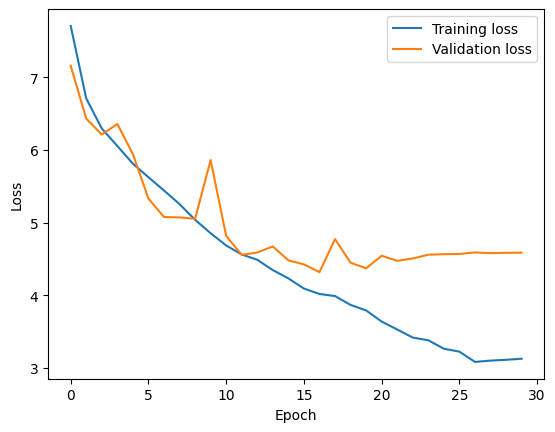

In [ ]:
x_range = np.arange(current_epoch)
plt.plot(x_range, loss_epochs, label='Training loss')
plt.plot(x_range, loss_val_epochs,  label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

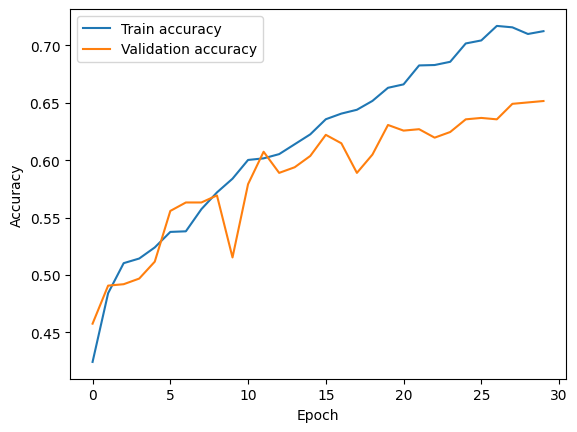

In [ ]:
plt.plot(x_range, acc_epochs, label='Train accuracy')
plt.plot(x_range, acc_eval_epochs,  label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

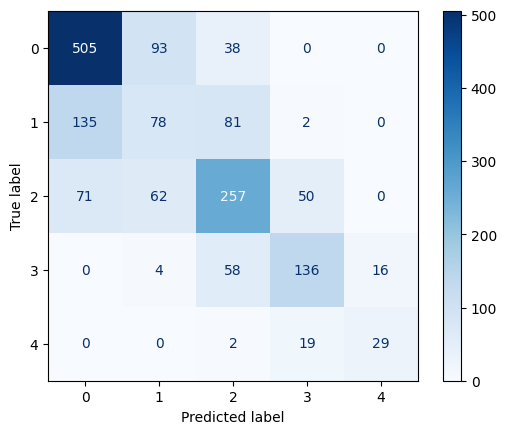

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(flattened_y_test, flattened_y_pred, labels=[0, 1, 2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2,3,4])

disp.plot(cmap = 'Blues')

plt.show()